In [12]:
using Unfold
using GLMakie
using PyMNE # MNE is a python library for EEG data analysis
using AlgebraOfGraphics # plotting Grammar of Graphics
using CSV
using DataFrames
using StatsBase # mean/std
using FileIO # loading data
using JLD2 # loading data
using StatsModels # UnfoldFit
using CairoMakie # Plotting Backend (SVGs/PNGs)
using Printf # interpolate strings
using DataFramesMeta # @subset etc. working with DataFrames
using StatsPlots
using Pipe
using UnfoldMakie

using ColorSchemes
using Query
using PyCall
using PyMNE
using ImageFiltering
pip = pyimport("pip")
pip.main(["install", "--upgrade", "mne"]);
import Conda
Conda.PYTHONDIR
run(`$(PyCall.python) -m pip install pymatreader`);
@pyimport pymatreader 


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [10]:
using TopoPlots

In [32]:

#ENV["PYTHON"] = "C:\Users\Vladimir\anaconda3\python.exe"
#Pkg.build("PyCall")
#@pyimport pymatreader 

In [7]:
begin # load  one single-subject dataset 
	p = "data/sub-002_ses-N170_task-N170_eeg.set"
    raw = PyMNE.io.read_raw_eeglab(p,preload=true)
    p_all = "data/erpcore-N170.jld2"
	presaved_data = load(p_all)
	dat_e = presaved_data["data_e_all"].* 1e6
	evt_e = presaved_data["df_e_all"]
	mon = PyMNE.channels.make_standard_montage("standard_1020")
	raw.set_channel_types(Dict("HEOG_left"=>"eog","HEOG_right"=>"eog","VEOG_lower"=>"eog"))
	raw.set_montage(mon,match_case=false)
	pos = PyMNE.channels.make_eeg_layout(get_info(raw)).pos
	pos = [Point2f(pos[k,1],pos[k,2]) for k in 1:size(pos,1)]
end;

In [13]:
begin
	# times vector (from-to)
	times = range(-0.3, length=size(dat_e,2), step=1 ./ 128)

	# get standard errors
	se_solver =(x,y)->Unfold.solver_default(x,y,stderror=true)
	# define effect-coding
	contrasts= Dict(:category => DummyCoding(), :condition => DummyCoding())
	
	analysis_formula = @formula 0 ~ 1 + category * condition
	
	results_allSubjects = DataFrame()
	
	for sub ∈ unique(evt_e.subject)

		# select events of one subject
	    sIx = evt_e.subject .== sub;

		# fit Unfold-Model
		# declaring global so we can access the variable outside of this loop (local vs. global scope)
	    global mres = Unfold.fit(UnfoldModel, 
						analysis_formula, 
						evt_e[sIx,:], 
						dat_e[:,:,sIx], 
						times, 
						contrasts=contrasts,
						solver=se_solver);

		# make results of one subject available
		global results_onesubject = coeftable(mres);

		# concatenate results of all subjects
	    results_onesubject[!,:subject] .= sub;
	    append!(results_allSubjects, results_onesubject);
	    
	end;
	
end;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Warning: Autocorrelation was NOT taken into account. Therefore SE are UNRELIABLE. Use at your own discretion
└ @ Unfold C:\Users\Vladimir\.julia\packages\Unfold\j4jUP\src\solver.jl:70
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Warning: Autocorrelation was NOT taken into account. Therefore SE are UNRELIABLE. Use at your own discretion
└ @ Unfold C:\Users\Vladimir\.julia\packages\Unfold\j4jUP\src\solver.jl:70
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Warning: Autocorrelation was NOT taken into account. Therefore SE are UNRELIABLE. Use at your own discretion
└ @ Unfold C:\Users\Vladimir\.julia\packages\Unfold\j4jUP\src\solver.jl:70
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Warning: Autocorrelation was NOT taken into account. Therefore SE are UNRELIABLE. Use at your own discretion
└ @ Unfold C:\Users\Vladimir\.julia\package

In [6]:
Makie.inline!(true)
CairoMakie.activate!(type="svg")

# 1. Lineplot

In [103]:
Dict(:category=>["face","car"],:condition=>["intact"])

Dict{Symbol, Vector{String}} with 2 entries:
  :condition => ["intact"]
  :category  => ["face", "car"]

In [33]:
using Unfold

res = effects(Dict(:category=>["face","car"],:condition=>["scrambled","intact"]), mres) # (design, model)
res = @subset(res, :channel .== 28)
plot_results(res);

### version 1

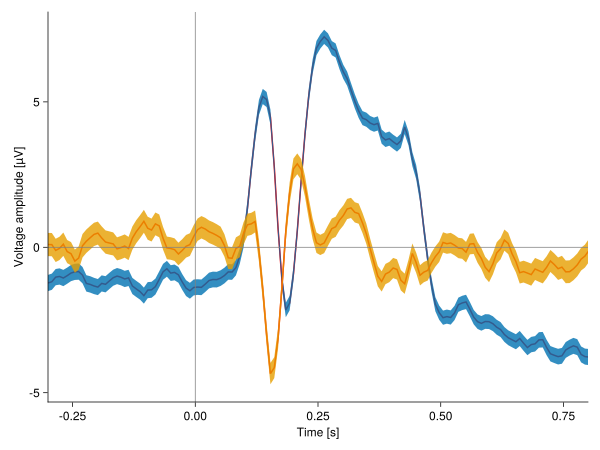

In [154]:
let
    data = filter(x -> x.coefname == "category: face" || x.coefname == "(Intercept)", results_allSubjects) 
    data.coefname = replace(data.coefname, "category: face" => "face", "(Intercept)" => "car")
    data = @pipe data |> 
            @subset(_, :channel .== 28) |> 
            rename!(_, :coefname => :conditions) |>
            groupby(_, [:time, :conditions]) |> 
            @transform!(_, :estimate_mean = mean(:estimate), :stderror_mean = mean(:stderror)./sqrt(nusbject))|> 
            @subset(_, :subject .== 1)  |> 
            select(_, Not([:basisname, :group, :channel, :subject, :estimate, :stderror]))
    
    f = Figure()
    ax = f[1, 1] = Axis(f,
            xlabel = "Time [s]", ylabel = "Voltage amplitude [µV]")
    
    for i in unique(data[:, :conditions])
            tmp = data[data[:, :conditions] .== i, :] 
            lines!(tmp.time, tmp.estimate_mean, label = i, linewidth = 2, color = :red)
            band!(tmp.time, tmp.estimate_mean-tmp.stderror_mean, tmp.estimate_mean+tmp.stderror_mean, 
            colormap=:viridis)
    end 
    
    hlines!(0, color = :gray, linewidth = 1)
    vlines!(0, color = :gray, linewidth = 1)
    CairoMakie.xlims!(-0.3,0.8)
    #f[1, 2] = Legend(f, ax, "Conditions", framevisible = false) 
    hidespines!(ax, :t, :r) # delete unnecessary spines (lines)
    hidedecorations!(ax, label = false, ticks = false, ticklabels = false) 
    f
    #save("plots/plot1.svg", f)
end

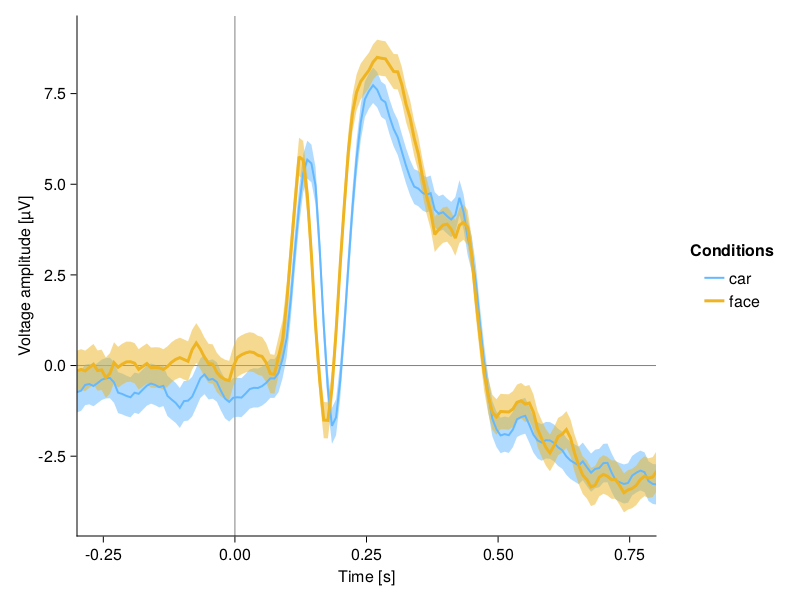

In [39]:
let
        data = filter(x -> x.coefname == "category: face" || x.coefname == "(Intercept)", results_allSubjects) 
        data.coefname = replace(data.coefname, "category: face" => "face", "(Intercept)" => "car")
        nusbject = length(unique(data[!, "subject"]))
        
        data = @pipe data |> 
                groupby(_, :channel) |> # baseline correction using lambda function 
                transform(_, [:estimate,:time] => (x,t) -> x .- mean(x[t .< 0])) |> 
                rename!(_, :estimate_time_function => :estimate_bsln_corrected) |>
                @subset(_, :channel .== 28) |> 
                rename!(_, :coefname => :conditions) |> 
                groupby(_, [:time, :conditions]) |> 
                @transform!(_, :estimate_mean = mean(:estimate_bsln_corrected), :stderror_mean = 2*(mean(:stderror)./sqrt(nusbject)))|> 
                @subset(_, :subject .== 1)  |> 
                select(_, Not([:basisname, :group, :channel, :subject, :estimate, :estimate_bsln_corrected, :stderror])) |>
                groupby(_, :time) |>
                @transform!(_, :sum_mean = sum(:estimate_mean))|> 
                @transform!(_, :sum_band = sum(:stderror_mean))|> 
                @subset(_, :conditions .== "car") 


        f = Figure()
        ax = f[1, 1] = Axis(f,
                xlabel = "Time [s]", ylabel = "Voltage amplitude [µV]")
        hlines!(0, color = :gray, linewidth = 1)
        vlines!(0, color = :gray, linewidth = 1)
        band!(data.time, data.estimate_mean - data.stderror_mean, data.estimate_mean + data.stderror_mean, color = (:steelblue1, 0.5)) #colormap=:viridis)
        band!(data.time, data.sum_mean - data.stderror_mean, data.sum_mean + data.stderror_mean, color = (:goldenrod2, 0.5))
                
        lines!(data.time, data.estimate_mean, label = "car", color = :steelblue1, linewidth = 2)
        lines!(data.time, data.sum_mean, label = "face",  color = :goldenrod2, linewidth = 3)

        CairoMakie.xlims!(-0.3,0.8)
        f[1, 2] = Legend(f, ax, "Conditions", framevisible = false) 
        hidespines!(ax, :t, :r) # delete unnecessary spines (lines)
        hidedecorations!(ax, label = false, ticks = false, ticklabels = false) 
        f
        #save("plots/plot1.svg", f)
end


- band transparency
- baseline correction
- change the way of computin of bands because we need another level of uncertainty



# 2. Butterfly plot

In [9]:
data = @pipe results_onesubject |> 
        select(_, Not([:basisname, :group])) |>
        #@subset(_, :channel .< 3) |>
        #@subset(_, :coefname .== ("category: face")) #|>
        @subset(_, :coefname .== ("(Intercept)")) |>
        #@transform(_, :channel = string.(:channel)) 
        groupby(_, :channel) |> 
        transform(_, [:estimate,:time] => (x,t) -> x .- mean(x[t .< 0])) |> # baseline correction using lambda function 
        rename!(_, :estimate_time_function => :estimate_bsln_corrected) |>
        @subset(_, :estimate_bsln_corrected .== maximum(:estimate_bsln_corrected))
data

1×7 DataFrame
 Row │ channel  coefname     estimate  stderror  time     subject  estimate_bs ⋯
     │ Int64    String       Float64   Float64   Float64  Int64    Float64     ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │      32  (Intercept)   6025.19   17.3201  0.85625       40              ⋯
                                                                1 column omitted

In [10]:
using LinearAlgebra
function eegHeadMatrix(positions, center, radius)
    oldCenter = mean(positions)
    oldRadius, _ = findmax(x-> LinearAlgebra.norm(x .- oldCenter), positions)
    radF = radius/oldRadius
    return Makie.Mat4f(radF, 0, 0, 0,
                       0, radF, 0, 0,
                       0, 0, 1, 0,
                       center[1]-oldCenter[1]*radF, center[2]-oldCenter[2]*radF, 0, 1)
end

struct NullInterpolator <: TopoPlots.Interpolator
        
end

function (ni::NullInterpolator)(
        xrange::LinRange, yrange::LinRange,
        positions::AbstractVector{<: Point{2}}, data::AbstractVector{<:Number})

    return zeros(length(xrange),length(yrange))
end
function posToColor(pos)
    cx = 0.5 - pos[1]
    cy = 0.5 - pos[2]
    rx = cx * 0.7071068 + cy * 0.7071068
    ry = cx * -0.7071068 + cy * 0.7071068
    b = 1.0 - (2*sqrt(cx^2+cy^2))^2
    return RGB(0.5 - rx*1.414, 0.5 - ry*1.414, b)
end

posToColor (generic function with 1 method)

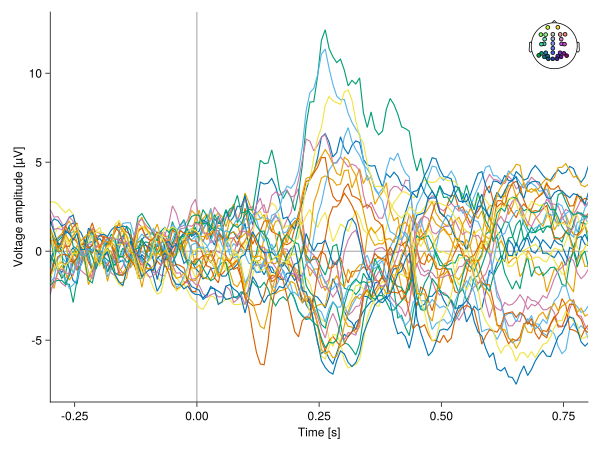

In [13]:
let 
    data = @pipe results_onesubject |> 
        select(_, Not([:basisname, :group])) |>
        @subset(_, :channel .< 32 ) |>
        @subset(_, :coefname .== ("(Intercept)")) |>
        groupby(_, :channel) |> 
        transform(_, [:estimate,:time] => (x,t) -> x .- mean(x[t .< 0])) |> # baseline correction using lambda function 
        rename!(_, :estimate_time_function => :estimate_bsln_corrected)

    f = Figure()
    ax = f[1, 1] = Axis(f,# xticks = map(x -> round(x, digits = 2) , range(minimum(data.time), stop = maximum(data.time), length = 5)), 
    xlabel = "Time [s]", ylabel = "Voltage amplitude [µV]")
    hidespines!(ax, :t, :r) 
    CairoMakie.xlims!(-0.3,0.8)
    hlines!(0, color = :gray, linewidth = 1)
    vlines!(0, color = :gray, linewidth = 1)

    N = 1:length(pos) #1:4 
    for i in N #unique(data[:, :channel])
        tmp = data[data[:, :channel] .== i, :] 
        lines!(tmp.time, tmp.estimate_bsln_corrected)
    end 
    hidedecorations!(ax, label = false, ticks = false, ticklabels = false) 
    #Colorbar(f[1, 2] , limits = (1, length(unique(data[:, :channel]))), label = "Channels")
    xmove = 700 # how to find these values automatically?
    ymove = 500
    axis = Axis(f, bbox = BBox(xmove, xmove+78, ymove, ymove+78))
  

	Makie.xlims!(low = -0.2, high = 1.2)
	Makie.ylims!(low = -0.2, high = 1.2)
    topoMatrix = eegHeadMatrix(pos[N], (0.5, 0.5), 0.5)
    specialColors = ColorScheme(vcat(RGB(1,1,1.),[posToColor(pos) for pos in pos[N]]...))

    topoplot = eeg_topoplot!(axis, N, # go from 1:npos
        string.(N); 
        positions = pos[N],
        interpolation=NullInterpolator(), # inteprolator that returns only 0
        colorrange = (0, length(pos)), # add the 0 for the white-first color
        colormap = specialColors,
        head = (color=:black, linewidth=1, model = topoMatrix))

    hidedecorations!(current_axis())
    hidespines!(current_axis())

    f
    #save("plots/plot2.svg", f)
end

- topoplot do not react on the change of channel numbers

# 3. Single topoplot

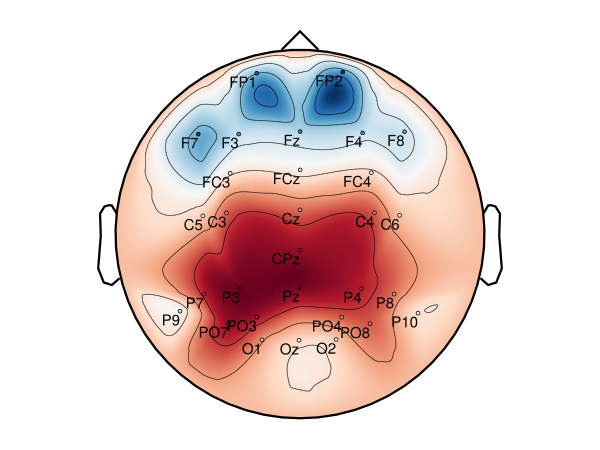

In [15]:
let 
    eeg_topoplot(mean(dat_e[1:30, 100, :], dims=2)[:,1], # averaging all trial of 30 participants on 100th msec
        raw.ch_names[1:30]; 
        positions=pos, # produced  automatically from ch_names
        label_text=true,
        axis=(aspect=DataAspect(),)) # aspect ratio, correlation of height and width
    hidedecorations!(current_axis())
    hidespines!(current_axis())
    current_figure()
    f = current_figure()
    #save("plots/plot3.svg", f)
end


In [1]:
using TopoPlots

- TopoPlot library should be updated soon -> pull request new unregistered yet version

# 4. Topographic map

In [10]:
let
    # in progress 
    TopoPlots.eeg_topoplot_series(mean(dat_e[1:30, :, :],dims=3)[:,:,1], 50; 
    positions=pos,
    label_text=true,
    axis=(aspect=DataAspect(),))

end


LoadError: UndefVarError: eeg_topoplot_series not defined

- fork current version of TopoPlot and merge #3 and #15
- remove current version of TopoPlot
- add https://github.com/vladimir/TopoPlots.jl 

# 5. Topoplot array

# 5.0. 


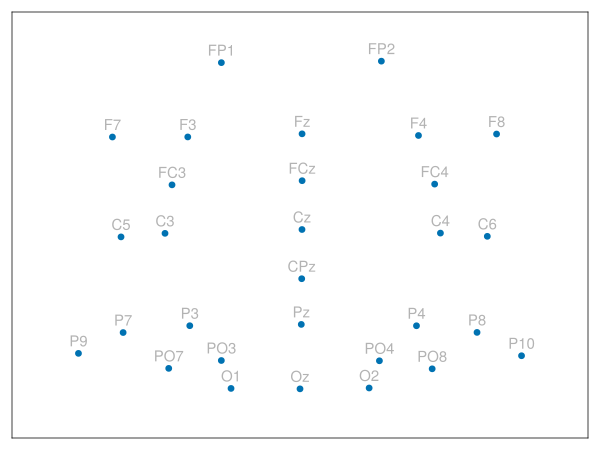

In [577]:
# layout observation
let
    f = Figure()
    ax = Axis(f[1, 1], #yreversed = true,
    xautolimitmargin = (0.15, 0.15),
    yautolimitmargin = (0.15, 0.15)
    )
    hidedecorations!(ax)
    CairoMakie.scatter!(pos)

    text!(pos, text = raw.ch_names[1:30], color = :gray70, offset = (0, 5),
        align = (:center, :bottom))
    f
end

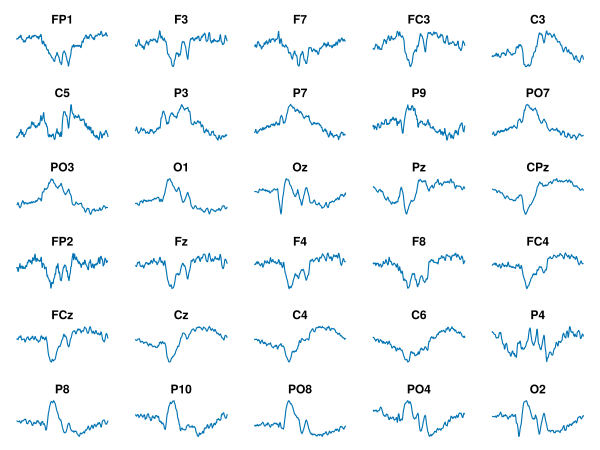

In [360]:
# grid version
let 
    data = @pipe results_onesubject |> 
        @subset(_, :channel .< 31 ) |>
        @subset(_, :coefname .== ("(Intercept)")) |>
        select(_, Not([:basisname, :group, :subject, :coefname])) |>

        groupby(_, :channel) |> 
        transform(_, [:estimate,:time] => (x,t) -> x .- mean(x[t .< 0])) |> # baseline correction using lambda function 
        rename!(_, :estimate_time_function => :estimate_bsln_corrected)


    f = Figure()
    row = 1
    col = 1
    for i in 1:30
        ax = Axis(f[row, col], title = raw.ch_names[i]) # attribte for position 
        col = col + 1
        if i % 5 .== 0
            col = 1 
            row = row + 1 
        end
        hidespines!(ax) 
        hidedecorations!(ax)
        tmp = data[data[:, :channel] .== i, :] 
        lines!(tmp.time, tmp.estimate_bsln_corrected)
    end
    f
    #save("plots/plot5.svg", f)
end

# 5.1

In [10]:
# important functions for the main plot
function del_empt2(coord)
    # searching for unsued coordinates

    tmp = Array(minimum(coord):maximum(coord))
    unused = []
    for i in tmp
        if !(i in coord)
            append!(unused, i)
        end
    end
    
    # creation of new coordinates without empty ones
    newcoord = []
    for i in coord
        q = 0
        for j in unused  
            if i > j
                q = findall(x->x==j, unused)[1]
            end
        end
        append!(newcoord, i - q)
    end 
    newcoord
end

function del_empt(pos)
    x = [i[1] for i in pos]
    y = [i[2] for i in pos]
    
    x = round.(x; digits=2)
    y = Integer.(round.((y .- mean(y))  * 20)) * -1
    x = Integer.(round.((x .- mean(x))  * 20))

    newx = del_empt2(x)
    newy = del_empt2(y)

    # twiching the lateral electodes' positons
    ma = findall(xx->xx==maximum(newx), newx)[1]
    mi = findall(xx->xx==minimum(newx), newx)[1]
    newx[mi] = newx[mi] + 1
    newx[ma] = newx[ma] - 1
    # return
    newx, newy
end

del_empt (generic function with 1 method)

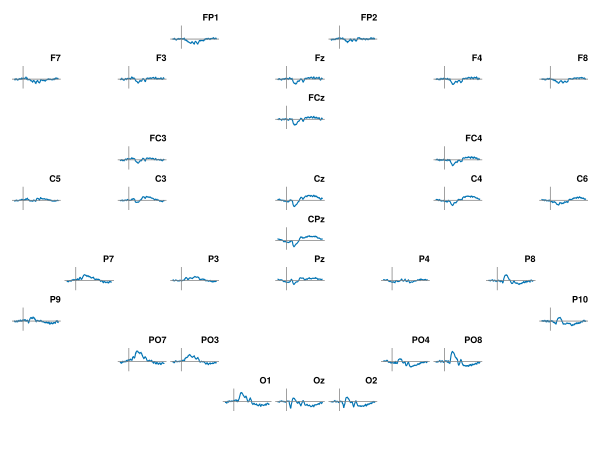

In [243]:
# the main plot
let 
    data = @pipe results_onesubject |> 
        @subset(_, :channel .< 31 ) |>
        @subset(_, :coefname .== ("(Intercept)")) |>
        select(_, Not([:basisname, :group, :subject, :coefname])) |>
        groupby(_, :channel) |> 
        transform(_, [:estimate,:time] => (x,t) -> x .- mean(x[t .< 0])) |> # baseline correction using lambda function 
        rename!(_, :estimate_time_function => :estimate_bsln_corrected)

    f = Figure()
    gl = f[1, 1] = GridLayout()
    x, y = del_empt(pos)

    for i in 1:30
        col = x[i]
        row = y[i]

        if (row == -1 && col == 0)
            col = 1
        end
        if (row == -8 && col == 1)
            col = 2
        end
        ax = Axis(gl[row, col], title = raw.ch_names[i], #string(row, ' ',  col),
        titlealign = :right, titlesize = 12) # attribte for position 
        #println(raw.ch_names[i], " ",  row, " ", col)
        hidespines!(ax) 
        hidedecorations!(ax)
        tmp = data[data[:, :channel] .== i, :] 
        lines!(tmp.time, tmp.estimate_bsln_corrected)
        hlines!(0, color = :gray, linewidth = 1)
        vlines!(0, color = :gray, linewidth = 1)
        Makie.ylims!(low = -10, high = 14)
        #Makie.limits!(ax, BBox(-2, 2, -2, 2))
    end
    Makie.colgap!(gl, 5)
    Makie.rowgap!(gl, 5)
    f
    #save("plots/plot5.1.svg", f)
end


- allign coordinates

# 5.2

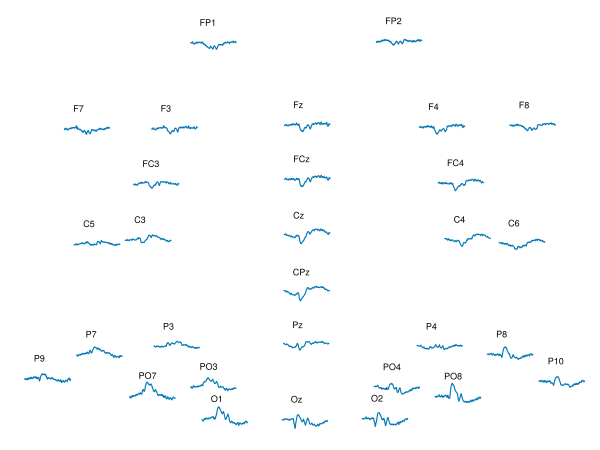

In [145]:
begin
    data = @pipe results_onesubject |> 
        @subset(_, :channel .< 31 ) |>
        @subset(_, :coefname .== ("(Intercept)")) |>
        select(_, Not([:basisname, :group, :subject, :coefname])) |>
        groupby(_, :channel) |> 
        transform(_, [:estimate,:time] => (x,t) -> x .- mean(x[t .< 0])) |> # baseline correction using lambda function 
        rename!(_, :estimate_time_function => :estimate_bsln_corrected)
        
    
    fig = Figure()
    ax = Axis(fig[1, 1])

    i = 1
    Makie.xlims!(low = 20, high = 170)
    Makie.ylims!(low = 30, high = 200)
    
    xs = 0:0.01:10
    ys = 0.5 .* sin.(xs)

    xscale = 8
    yscale = 0.5
    
    for i in 1:30
        xmove = pos[i][1] * 200
        ymove =  pos[i][2] * 200 
        #println(raw.ch_names[i], " ", xmove, " ", ymove, " ")
        m4x4 = Makie.Mat4f(xscale, 0, 0, 0,
                        0, yscale, 0, 0,
                        0, 0, 1, 0,
                        xmove, ymove , 0, 1)
        tmp = data[data[:, :channel] .== i, :] 
        lines!(tmp.time, tmp.estimate_bsln_corrected, model = m4x4, color = "#0077b6")
        text!(xmove, ymove + 6, text = raw.ch_names[i], 
        align = (:left, :bottom), color = :black,
        textsize = 12)
        #hlines!(xmove, color = :black, linewidth = 1, model = m4x4)
        vlines!(0,  xmin = minimum(tmp.estimate_bsln_corrected),
        xmax = maximum(tmp.estimate_bsln_corrected),  color = :red, linewidth = 1)
    end

    hidespines!(ax) 
    hidedecorations!(ax)
    fig
    #save("plots/plot5.svg", fig)
end

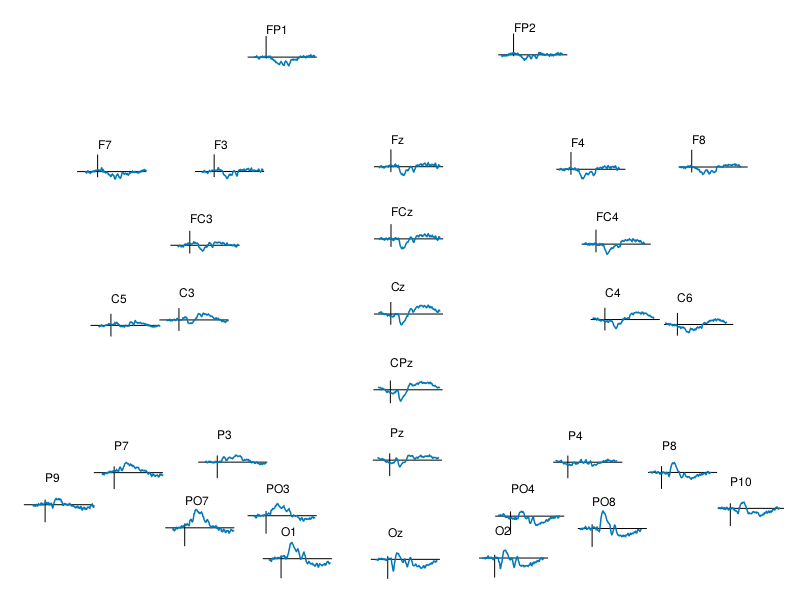

In [44]:
begin
    data = @pipe results_onesubject |> 
        @subset(_, :channel .< 31 ) |>
        @subset(_, :coefname .== ("(Intercept)")) |>
        select(_, Not([:basisname, :group, :subject, :coefname])) |>
        groupby(_, :channel) |> 
        transform(_, [:estimate,:time] => (x,t) -> x .- mean(x[t .< 0])) |> # baseline correction using lambda function 
        rename!(_, :estimate_time_function => :estimate_bsln_corrected)
        
    
    fig = Figure()
    ax = Axis(fig[1, 1])

    Makie.xlims!(low = 20, high = 170)
    Makie.ylims!(low = 30, high = 200)
    

    xscale = 8
    yscale = 0.5
    
    for i in 1:30
        xmove = pos[i][1] * 200
        ymove =  pos[i][2] * 200 
        #println(raw.ch_names[i], " ", xmove, " ", ymove, " ")
        m4x4 = Makie.Mat4f(xscale, 0, 0, 0,
                        0, yscale, 0, 0,
                        0, 0, 1, 0,
                        xmove, ymove , 0, 1)
        tmp = data[data[:, :channel] .== i, :]
        a = pos[i][1] 
        a = (a + (a - 0.4660183)* 0.35)  
        b = a + 0.09 
        hlines!(ymove, xmin = a, xmax = b, 
         color = :black, linewidth = 1)

        a = pos[i][2] 
        a = a - (1 - a)/3.2* 0.7 
        #a = a - (0.96 - a)/3.2* 0.7
        b = a + 0.04 
        vlines!(xmove, ymin = a, ymax = b, color = :black, linewidth = 1)

        lines!(tmp.time, tmp.estimate_bsln_corrected, model = m4x4, color = "#0077b6")
        text!(xmove, ymove + 6, text = raw.ch_names[i], 
        align = (:left, :bottom), color = :black,
        textsize = 12)
    
        #println(raw.ch_names[i], " ", pos[i][2] , " ",  a )
    end

    hidespines!(ax) 
    hidedecorations!(ax)
    fig
    #save("plots/plot5.svg", fig)
end

# 5.3

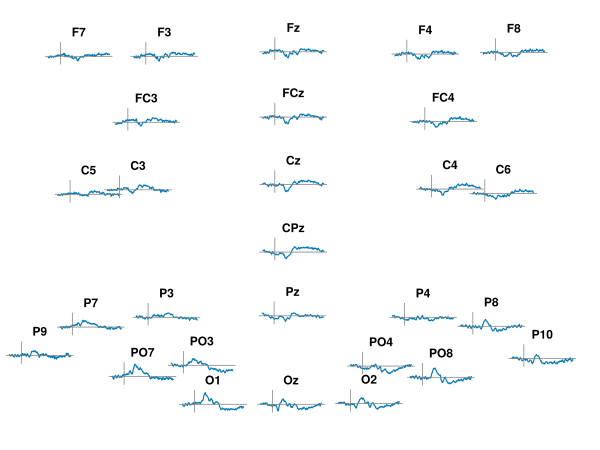

In [16]:
begin
    data = @pipe results_onesubject |> 
        @subset(_, :channel .< 31 ) |>
        @subset(_, :coefname .== ("(Intercept)")) |>
        select(_, Not([:basisname, :group, :subject, :coefname])) |>
        groupby(_, :channel) |> 
        transform(_, [:estimate,:time] => (x,t) -> x .- mean(x[t .< 0])) |> # baseline correction using lambda function 
        rename!(_, :estimate_time_function => :estimate_bsln_corrected)
        
    
    f = Figure()

    for i in 1:30
        xmove = pos[i][1] *1000 - 120
        ymove =  pos[i][2]  * 800 - 100
        ax = Axis(f, bbox = BBox(xmove, xmove+90, ymove, ymove+30), title = string(raw.ch_names[i]))
        tmp = data[data[:, :channel] .== i, :] 
        lines!(ax, tmp.time, tmp.estimate_bsln_corrected,  color = "#0077b6") #, model = m4x4)
        hlines!(0, color = :gray, linewidth = 1)
        vlines!(0, color = :gray, linewidth = 1)
        hidespines!(ax) 
        hidedecorations!(ax)
        Makie.ylims!(low = -8, high = 14)
        
    end

    f
    #save("plots/plot5.svg", f)
end

- coordinate lines to indicate where is zero for time ad voltage - vline is badly alligned

# 6. ERP image
only for 1 channel

In [97]:
size( dat_e) # channels, time, trials

(33, 193, 8576)

In [55]:
let
    f = Figure()
    ga = f[1, 1] = GridLayout()

    ax1 = Axis(ga[1:4, 1], xlabel = "Time [s]", ylabel = "Sorted trials")
    ix = sortperm([a[1] for a in argmax(dat_e[28,:,:], dims=1)][1,:])    # ix - trials sorted by time of maximum spike

    xs = range(-0.3, 1.2, length = size(dat_e, 2))
    ys = 1:4000
    zs = Matrix(DataFrame(dat_e[30,:,ix][:, 2000:6000], :auto))
    hm = CairoMakie.heatmap!(xs, ys, zs, colormap=Reverse("RdBu"), colorrange = (-10, 10))  
    CairoMakie.xlims!(-0.3,0.8)
    
    ax2 = Axis(ga[5, 1], xlabel = "Time [s]", ylabel = "Voltage [µV]")
    ys2 = mean(dat_e[28,:,ix],dims=2)[:,1]
    xs2 = range(-0.3, 1.2, length = size(dat_e, 2))
    lines!(ax2, xs2, ys2)
    CairoMakie.xlims!(-0.3,0.8)
    CairoMakie.ylims!(-5, 10)
    hlines!(0, color = :gray, linewidth = 1)
    vlines!(0, color = :gray, linewidth = 1)
    
    CairoMakie.Colorbar(f[:, end+1], hm, label = "Voltage [µV]") 
    hidespines!(ax1, :t, :r)  
    hidespines!(ax2, :t, :r)  
    hidedecorations!(ax2, label = false, ticks = false, ticklabels = false) 
    f
    #save("plots/plot6.svg", f)
end

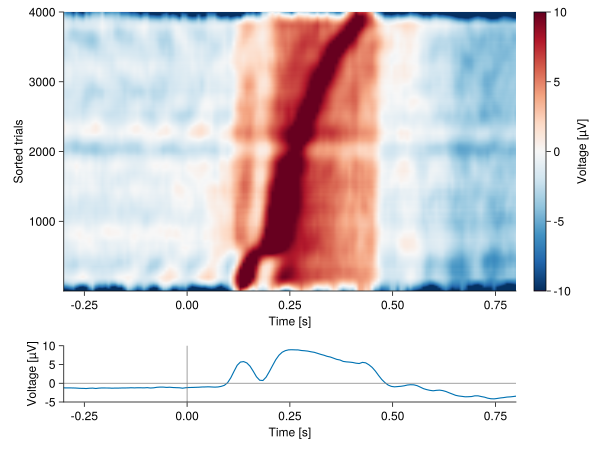

In [18]:
let
    f = Figure()
    ga = f[1, 1] = GridLayout()

    ax1 = Axis(ga[1:4, 1], xlabel = "Time [s]", ylabel = "Sorted trials")
    ix = sortperm([a[1] for a in argmax(dat_e[28,:,:], dims=1)][1,:])    # ix - trials sorted by time of maximum spike

    xs = range(-0.3, 1.2, length = size(dat_e, 2))
    #ys = 1:size(dat_e[28,:,:])[2]
    ys = 1:4000
    zs = Matrix(DataFrame(dat_e[30,:,ix][:, 2000:6000], :auto))

    zs = imfilter(zs, Kernel.gaussian((0, 100))) # @bycol - apply for each column
    #@show(size(zs))
    hm = CairoMakie.heatmap!(xs, ys, zs, colormap=Reverse("RdBu"), colorrange = (-10, 10))  
    CairoMakie.xlims!(-0.3,0.8)
    CairoMakie.Colorbar(ga[:, end+1], hm, label = "Voltage [µV]") 
    
    ax2 = Axis(ga[5, 1], xlabel = "Time [s]", ylabel = "Voltage [µV]")
    ys2 = mean(dat_e[28,:,ix],dims=2)[:,1]
    xs2 = range(-0.3, 1.2, length = size(dat_e, 2))
    lines!(ax2, xs2, ys2)
    CairoMakie.xlims!(-0.3,0.8)
    CairoMakie.ylims!(-5, 10)
    hlines!(0, color = :gray, linewidth = 1)
    vlines!(0, color = :gray, linewidth = 1)
    

    hidespines!(ax1, :t, :r)  
    hidespines!(ax2, :t, :r)  
    hidedecorations!(ax2, label = false, ticks = false, ticklabels = false) 
    f
    #save("plots/plot6.svg", f)
end

In [296]:
img = zeros(5,5); img[3,3] = 1

kern2 = KernelFactors.gaussian((100, 0))
imfilter(img, kern2)


5×5 Matrix{Float64}:
 0.0  0.0  0.00417641  0.0  0.0
 0.0  0.0  0.00417703  0.0  0.0
 0.0  0.0  0.00417724  0.0  0.0
 0.0  0.0  0.00417703  0.0  0.0
 0.0  0.0  0.00417641  0.0  0.0


- add smoothing by row, not by row and col


# 7.Parallel coordinates

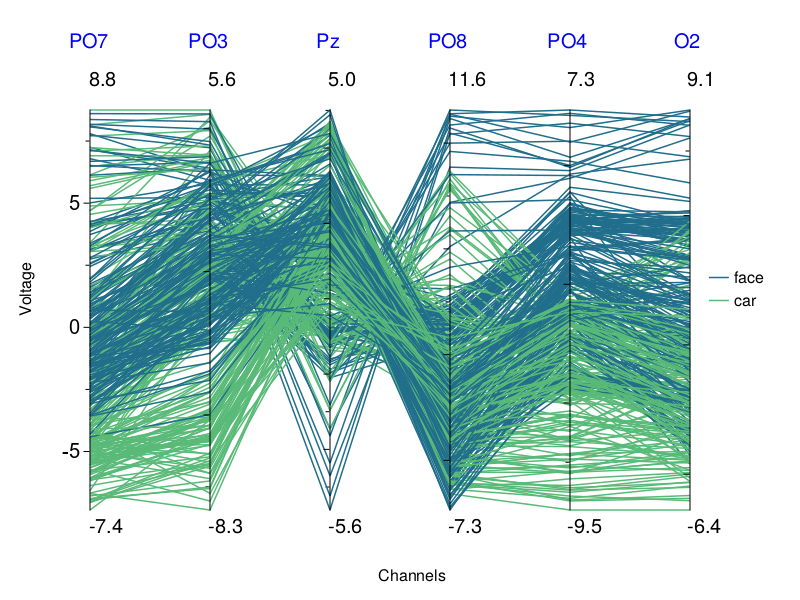

In [38]:
let
    channels = [10, 11, 14, 28, 29, 30] #[2, 3, 17, 18, 19] 
    ch = raw.ch_names[channels] 

    res = effects(Dict(:category=>["face", "car"], :condition=>["intact"]), mres)
    data = @pipe res |> 
        filter(x -> x.channel in channels, _) |>
        select(_, Not([:basisname, :condition])) 

    n = length(channels) # number of axis
    k = 20
    
    categories = unique(data.category)
    colors = Dict{String,RGBA{Float64}}()
    catLeng = length(categories)

    
    # get a colormap for each category
    bord = 1 # colormap border (prevents from using outer parts of color map)
    colormap = cgrad(:haline, (catLeng < 2) ? 2 + (bord*2) : catLeng + (bord*2), categorical = true)
    for i in eachindex(categories)
        setindex!(colors, colormap[i+bord], categories[i])
    end
    # axes
    f = Figure()
    width = 600;   height = 400 ;   offset = 90;   
    limits = [] ; l_low = [] ; l_up = []
    chaLeng = length(channels)
    
    for cha in channels
        tmp = filter(x -> (x.channel == cha),  data) 
        w = extrema.([tmp.yhat])
        append!(limits, w)
        append!(l_up, w[1][2])
        append!(l_low, w[1][1])

    end

    for i in 1:n
        x = (i - 1) / (n - 1) * width
        if i == 1
            switch = true
        else
            switch = false
        end
        Makie.LineAxis(f.scene,  limits = limits[i], # maybe consider as unique axis????
            spinecolor = :black, labelfont = "Arial", 
            ticklabelfont = "Arial", spinevisible = true,  ticklabelsvisible = switch, 
            minorticks = IntervalsBetween(2),  #tickcolor = :red, 
            endpoints = Point2f[(offset + x, offset), (offset + x, offset + height)],
            ticklabelalign = (:right, :center), labelvisible = false)
    end

    for j in unique(data.time) 
        tmp1 = filter(x -> (x.time == j),  data) #1 timepoint, 10 rows (2 conditions, 5 channels) 
        for cat in categories
            # df with the order of the channels
            dfInOrder = data[[],:]
            tmp2 = filter(x -> (x.category == cat),  tmp1)
            
            # create new dataframe with the right order
            for cha in channels
                append!(dfInOrder,filter(x -> (x.channel == cha),  tmp2))
            end
            
            values = map(1:n, tmp2.yhat, limits) do q, d, l # axes, data
                x = (q - 1) / (n - 1) * width
                Point2f(offset + x, (d - l[1]) ./ (l[2] - l[1]) * height + offset)     
                    end
            lines!(f.scene, values; color = colors[cat])
        end
    end 
    ax = f[1, 1] = Axis(f.scene)

    # helper, cuz without them they wouldn't have an entry in legend
    for cat in categories
        lines!(ax, 1, 1, 1, label = cat, color = colors[cat])
    end
    axislegend(ax, position = :rc, framevisible = false)

    hidespines!(ax) 
    hidedecorations!(ax, label = false) 

    ax.xlabel = "Channels";    ax.ylabel = "Voltage"
    # the width of the plot is set, so the labels have to be placed evenly
    x = Array(10:(380-10)/(chaLeng-1):380)
    # height of plot
    y = fill(105, chaLeng)

    ax = Axis(f[1, 1])
    
    text!(x, y, text = ch, align = (:center, :center), 
        offset = (0, 0), 
        color = :blue)
    
        
    text!(x, fill(5, chaLeng),  text = string.(round.(l_low, digits=1)))
    text!(x, fill(95, chaLeng),  text = string.(round.(l_up, digits=1)))

    Makie.xlims!(low = -20, high = 440)
    Makie.ylims!(low = 0, high = 110)

    hidespines!(ax) 
    hidedecorations!(ax, label = false) 
    #save("plots/plot7.svg", f)
    f 
 
   
end

- two versions with same and different min/max
- crowdiness: 1) transperansy 2) averaging across subjects?
- issue on makie
- try data from lineplots
- drop yticks from first axis
- are axes symmetric?

# 8. Channel image

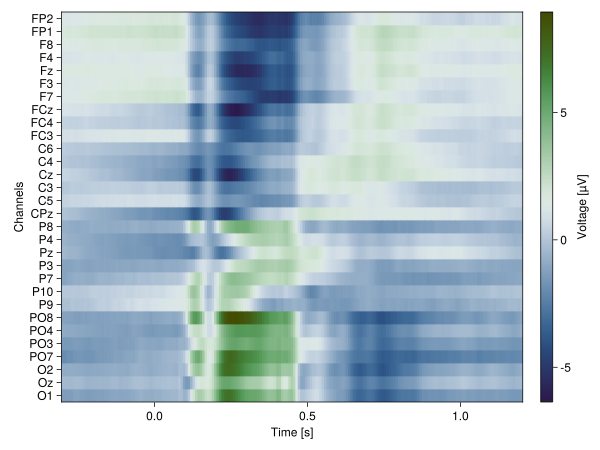

In [21]:
let 
    using CairoMakie
    x = [i[1] for i in pos]
    y = [i[2] for i in pos]
    
    x = round.(x; digits=2)
    y = Integer.(round.((y .- mean(y))  * 20)) * -1
    x = Integer.(round.((x .- mean(x))  * 20))
    d = zip(x, y, raw.ch_names, 1:30)
    a = sort!(DataFrame(d), [:2, :1], rev=[true, false])
    b = a[!, :4]
    c = a[!, :3]
    
    ix = range(-0.3, 1.2, length = size(dat_e, 2))
    iy = 1:30
    iz = mean(dat_e, dims=3)[b, :, 1]'
    #iz = imfilter(iz, Kernel.gaussian((1, 0)))
    f, ax, hm = CairoMakie.heatmap(ix, iy, iz, # how to reshape this into matrix???
       colormap="cork") # single trial
    ax = current_axis()
    ax.xlabel = "Time [s]"
    ax.ylabel = "Channels"
    ax.yticks = iy
    ax.ytickformat = xc -> c

    Colorbar(f[1, 2], hm,  label = "Voltage [µV]") 
    current_figure()
    #save("plots/plot8.svg", f)
end


- smoothing function could help to incease a resolution
- try data from lineplot

# Data

In [ ]:
let 
    #first(results_onesubject[:, !1], 5)
    #unique(results_onesubject[:, 2])
    data = @pipe results_onesubject |> 
        select(_, Not([:basisname, :group])) |>
        @subset(_, :channel .== 18) |>
        @transform(_, :channel = string.(:channel)) 
    data = filter(x -> x.coefname == "category: face" || x.coefname == "category: scrambled" , 
    data) 

    data
end